# Path Integral Montecarlo


## Setup
This first part of the code is used to set up the input parameters for the code. 

In [68]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 17:50:33 2019

@author: SQUANCHY-MC
"""

import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy
from fast_histogram import histogram1d
from scipy.interpolate import RegularGridInterpolator as rgi

# %%

"""Parameters, units: ueV, nm, ns"""

N = 1000 #time_steps and number of tried changes during one sweep.
num_path = 200 #number of sweeps
print('N, num_paths = ', N, num_path)

tau = 10**(-6) #length of time_step (ns)
beta = tau * N # imaginary total time? (/hbar?)
print('beta, tau = ', beta, tau)

time = np.linspace(0,beta,N)

delta_t = 0.5 # need to adjust such that average acceptance rate is 0.5 for bias
h = 2 # tried position change (step size) during Metropolis is from [-h/2,h/2]
#h = np.sqrt(delta_t) # recommended by Stones?
print('delta_t, h = ',delta_t, h)

bias = 0 # Turn on/off force bias scheme (1 or 0)
interaction = 1 # Turn on/off electron-electron interaction (1 or 0)

if bias == 0:
    print('No Bias')
elif bias == 1:
    print('Bias')
    
if interaction == 0:
    print('No Interaction')
elif interaction == 1:
    print('Interaction')
    
# %%


N, num_paths =  1000 200
beta, tau =  0.001 1e-06
delta_t, h =  0.5 2
No Bias
Interaction


## List of Constants

In [114]:

me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass

mass = 1 # Effective mass on/off
if mass == 1:
    meff= 0.2 * me #effective electron mass in Silicon
    ml = 0.98 * me #effective mass in longitudinal k-direction
    mt = 0.19 * me #effective mass in transverse k-direction
    mx = mt #effective mass in x-direction
    my = mt #effective mass in y-direction
    mz = ml #effective mass in z-direction
    m = np.array([mx,my,mz])
    print('Mass')
else:
    print('No Mass')

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon
w = 4000/hbar #10**(4) #ns-1
q = 10**6 #ueV
lamda = 0.5 * hbar**2 / me
r_0 = math.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV / nm - Electric field in z direction
pot_step = 3 * 10**6 #ueV - Si/SiO2 interface



Mass


## Potentials

In [145]:

# %%
"""Different potentials"""    
def V_2d(x,y):
    return 0.5 * me * w**2 * (x**2 + y**2)

def dV_2d(x,y):
    return [me * w**2 * x, me * w**2 * y, 0]

x_0 = 1.5*r_0
def double_HO(x):
    return 0.5 * me * w**2 * min((x-x_0)**2,(x+x_0)**2)
    
def dV_double_HO(x):
    return [me * w**2 * min(x-x_0, x+x_0), 0, 0]
    
def V_HO1d(y):
    return 0.5 * me * w**2 * y**2

def dV_HO1d(y):
    return me * w**2 * y

# Heterostructure interface potential (z-direction) leading to airy functions as wave function.
a=10
slope = E_z
V = pot_step
def V_step(z):
    return(V / (np.exp(-a*z) + 1) + interpolate((0,0,z))) # HRL potential used as slope in z direction
    '''if z<0:
        return(V / (np.exp(a*z) + 1) - slope * z)
    elif z>2:
        return(slope *z)
    else:
        return(V / (np.exp(a*z) + 1) + slope * z)'''
    #return(V / (np.exp(-a*z) + 1))

    
def dV_step(z):
    return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2)])
    '''if z<0:
        return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2) - slope])
    elif z>2:
        return([0,0,slope])
    else:
        return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2) + slope])'''

def dist(r1,r2):
    return(np.sqrt(np.dot(np.subtract(r1,r2),np.subtract(r1,r2))))

def ee(r1,r2): # electron interaction
    return(1.23*10**5/dist(r1,r2))

xs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['xs']
ys = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ys']
zs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['zs']
ephi = 10**6 * np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ephi'] # 10^6 for ueV


# This is the point where Andre found a problem
# This is the point where Andre found a problem
# This is the point where Andre found a problem
# This is the point where Andre found a problem

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False)

def V_hrl(point):
    return interpolate(point)[0] + V_step(point[2])

def V_doubledot(point):
    return double_HO(point[0]) + V_HO1d(point[1]) + V_step(point[2])

def dV_doubledot(point):
    return np.add(np.add(dV_double_HO(point[0]),dV_HO1d(point[1])),dV_step(point[2]))

def V_het(point): # Scalar potential of field @ position
    return V_2d(point[0],point[1]) + V_step(point[2])

def dV_het(point): # 3d gradient of field @ position
    return np.add(dV_2d(point[0],point[1]),dV_step(point[2]))

def dV_zero(point):
    return np.multiply(bias,[1,1,1])



In [131]:
np.multiply(bias,[1,1,1])

array([0, 0, 0])

In [72]:

"""
Sweep references (d)V_field, change here for potential
Even with bias off, gradient is computed, could avoid with if loops
"""

'''V_field = V_doubledot
dV_field = dV_doubledot
print('Double Dot')'''
V_field = V_hrl
# dV_field = dV_zero # Use this if no bias to reduce computational time, didn't implement gradient of HRL, interpolated gradient took too much computational time
print('HRL')

# %%
""" If you want analyse aspects of potential in 1D"""
def plot_potential(potl):
    z = np.linspace(-2,2,1000)
    V = np.zeros(1000)
    for i in range(0,1000):
        V[i] = potl(z[i])
    plt.plot(z,V[2],color='g')
    #histo1(2,path_list1)
    #plt.xlim(0,2)
    #plt.ylim(0,20000)
    plt.show()

# %%



HRL


## Methods for path generation, crossings and staying

In [73]:

"""
Generating paths of length N
Choice of 'hot' (random) or 'cold' paths, need to adjust to suit potential (size/distance b/w dots)
Force path to cross/stay in dots, need to adjust to suit potential (size/distance b/w dots)
"""

def generate_path(N):
    '''path1 = np.zeros((3,N)) #Initial path: "Cold start"
    path2 = -25 * np.ones((3,N))
    print('Cold Inital Path')'''
    pathx = np.random.uniform(-52,0,N)
    pathy = np.random.uniform(-10,10,N)
    pathz = np.random.uniform(-2,0,N)
    path = np.array([pathx,pathy,pathz])
    return path

def crossing(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -5.0
    path2[0][0] = 5.0
    path2[0][len(path2[0])-1] = -47.0
    print('Crossing')
" Set for HRL potential "
def staying(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -47.0
    path2[0][0] = -5.0
    path2[0][len(path2[0])-1] = -5.0
    print('Staying')
    

### Creating paths

Hot Initial Path


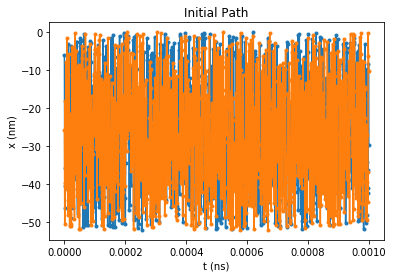

In [74]:
#Creating path1 and path2

path1 = generate_path(N)
path2 = generate_path(N)
print('Hot Initial Path')    
#crossing(path1,path2)
#staying(path1,path2)


"""
Lists for details of paths to be saved after each sweep
Creating lists of details (list of paths, actios, rates of accuracy, tunneling, cooled)
"""
# Copy path1(2) to the first item in the path list1(2). 
path_list1 = [0] * num_path #path at the end of each sweep
path_list1[0] = deepcopy(path1)
path_list2 = [0] * num_path #path at the end of each sweep
path_list2[0] = deepcopy(path2)

action_list1 = [0] * num_path
action_list2 = [0] * num_path
action_list = [0] * num_path

accrate_list1 = [0] * num_path
accrate_list2 = [0] * num_path
accrate_list = [0] * num_path

tunnelling_list1 = [0] * num_path
tunnelling_list2 = [0] * num_path
tunnelling_list = [0] * num_path

cooled_tunnelling_list1 = [0] * num_path
cooled_tunnelling_list2 = [0] * num_path
cooled_tunnelling_list = [0] * num_path


""" Plots path position over time """

def plot_paths():
    plt.plot(time,path_list1[0][0],'.-')
    plt.plot(time,path_list2[0][0],'.-')
    #plt.xlim(0,0.01) #If random paths then can just look at shorter segments for clarity
    plt.title('Initial Path')
    plt.xlabel('t (ns)')
    plt.ylabel('x (nm)')
    plt.show()
    
plot_paths()


In [79]:
np.shape(ee(path1,path2))
sum(ee(path1,path2))

11310066.402161827

# STOP HERE! . TRYING TO VECTORIZE THE CODE. NEED TO CREATE VECTORIZED FORM OF HML

In [146]:
# np.shape(ee(path1,path2))
# ee(path1,path2)

# %%




######## Need to verify the definition of this action. Something is strange in s1
######## COMENTED V_FIELD TO MAKE COMPUTATIONS


""" returns action of system """
def find_action(path1,path2): 
    s1 = 0
    s2 = 0
    V_interaction = 0
    for i in range(len(path1[0])-1):
        V_interaction += interaction * ee(path1[:,i],path2[:,i])
        s1 += 0.5 * (np.dot(m,(path1[:,i+1]-path1[:,i])**2)) / tau #+ tau * (V_field(path1[:,i]))# + V_interaction)
        s2 += 0.5 * (np.dot(m,(path2[:,i+1]-path2[:,i])**2)) / tau #+ tau * (V_field(path2[:,i]))# + V_interaction)
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s

import time
start_time = time.time()
for i in range(1000):
    find_action(path1,path2)
print("Value of the action. ----", find_action(path1,path2))
print("--- %s seconds ---" % (time.time() - start_time))


Value of the action. ---- 576972.1402601235
--- 18.450040102005005 seconds ---


## Same computation with new vectorized potentials 

    1 The first validation was a complete success
    2 It is necessary to vectorize all p

In [147]:
# New vectorized potentials 

def dist(r1,r2):
    minus = r1-r2
    return np.sqrt(minus[0,:]**2 + minus[1,:]**2 + minus[2,:]**2)

def find_action(path1,path2):
    V_interaction = interaction * sum(ee(path1,path2))
    s1 = (.5/tau)*sum(np.matmul(np.transpose(m),(path1[:,1:]-path1[:,:-1])**2))    
    s2 = (.5/tau)*sum(np.matmul(np.transpose(m),(path2[:,1:]-path2[:,:-1])**2))
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s

start_time = time.time()
for i in range(1000):
    find_action(path1,path2)
print("Value of the action. ----", find_action(path1,path2))
print("--- %s seconds ---" % (time.time() - start_time))


Value of the action. ---- 576972.1465610999
--- 0.4170558452606201 seconds ---


In [129]:
m
i = 10 
np.dot(m,(path1[:,i+1]-path1[:,i])**2)
V_field(path1[:,i])

747196.7407536482

In [121]:
np.shape(path1[:,1:]-path1[:,:-1])
newarrr = np.matmul(np.transpose(m),(path1[:,1:]-path1[:,:-1])**2)
np.shape(newarrr)

(999,)

In [81]:



   
""" Compares path w/o first element w/ path w/o last element, multiplying 0th*1st, 1st*2nd etc. and summing all sign changes """
def tunnelling_rate(path):
    tunnellings = (((path[0][:-1]+26) * (path[0][1:]+26)) < 0).sum() # +26 to shift for HRL potential (local max)
    rate = tunnellings/len(path)
    return tunnellings, rate

# %%

def plot_meshgrid(path):

    H, xedges, yedges = np.histogram2d(path[0,:],path[1,:],bins=10)
    H = H.T  # Let each row list bins with common y range.
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(132, title='pcolormesh: actual edges',aspect='equal')
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, H)

    
    #fig = plt.figure()
    #ax = fig.gca(projection='3d')
    
    # Make data.
    #X1 = np.arange(-5, 5, 0.25)
    #Y2 = np.arange(-5, 5, 0.25)
    #X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R)
    plt.show()
    
#plot_meshgrid(path1)
#plot_meshgrid(path2)

# %%

"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""

def sweep():
    s=0 # Action change during the sweep
    s1=0
    s2=0
    
    accrate=0 # accuracy rate
    accrate1=0
    accrate2=0
    
    index=np.random.uniform(1,N-1,N) # Order in which path changes are tried. Endpoints (0 and N-1) kept fixed.
    metropolis_comparison = np.random.uniform(0,1,N)
    
    rand_x_1=np.random.uniform(0,1,N) # Creating N random numbers.
    rand_y_1=np.random.uniform(0,1,N)
    rand_z_1=np.random.uniform(0,1,N)
    
    rand_x_2=np.random.uniform(0,1,N) # Creating N random numbers.
    rand_y_2=np.random.uniform(0,1,N)
    rand_z_2=np.random.uniform(0,1,N)
    
    for i in range(0,N):
        time=int(index[i])
        time_p=int((time+1))
        time_m=int((time-1))
                
        """
        Calculating change in action due to replacing path[time] by x_new. Different potentials considered.
        """
        
        so1_px = (path1[0,time_p]-path1[0,time])**2
        so1_py = (path1[1,time_p]-path1[1,time])**2
        so1_pz = (path1[2,time_p]-path1[2,time])**2
        so1_mx = (path1[0,time]-path1[0,time_m])**2
        so1_my = (path1[1,time]-path1[1,time_m])**2
        so1_mz = (path1[2,time]-path1[2,time_m])**2
        
        so2_px = (path2[0,time_p]-path2[0,time])**2
        so2_py = (path2[1,time_p]-path2[1,time])**2
        so2_pz = (path2[2,time_p]-path2[2,time])**2
        so2_mx = (path2[0,time]-path2[0,time_m])**2
        so2_my = (path2[1,time]-path2[1,time_m])**2
        so2_mz = (path2[2,time]-path2[2,time_m])**2
        
        T_old1x = 0.5 * mx * (so1_px + so1_mx) / tau**2
        T_old1y = 0.5 * my * (so1_py + so1_my) / tau**2
        T_old1z = 0.5 * mz * (so1_pz + so1_mz) / tau**2
        T_old2x = 0.5 * mx * (so2_px + so2_mx) / tau**2
        T_old2y = 0.5 * my * (so2_py + so2_my) / tau**2
        T_old2z = 0.5 * mz * (so2_pz + so2_mz) / tau**2
        T_old1 = T_old1x + T_old1y + T_old1z
        T_old2 = T_old2x + T_old2y + T_old2z
        T_old = T_old1 + T_old2 # There would be a cleaner way to calculate this kinetic energy with dot products etc
        
        def V_spring(path):
            return np.dot(path[:,time_p] - path[:,time], path[:,time_p] - path[:,time]) / (4*lamda*tau) # different time?
        
        def dV_spring(path):
            return (path[:,time_p] - path[:,time] + path[:,time_m] - path[:,time]) / (4*lamda*tau)
        
        V_spring_old1 = V_spring(path1)
        V_spring_old2 = V_spring(path2) 
        dV_spring_old1 = dV_spring(path1)
        dV_spring_old2 = dV_spring(path2)
        
        V_field_old1 = V_field(path1[:,time])
        V_field_old2 = V_field(path2[:,time])
        dV_field_old1 = dV_field(path1[:,time])
        dV_field_old2 = dV_field(path2[:,time])

        V_interaction_old = interaction * ee(path1[:,time],path2[:,time])
        
        V_eff_old1 = V_field_old1 + V_spring_old1 
        V_eff_old2 = V_field_old2 + V_spring_old2
        V_eff_old = V_eff_old1 + V_eff_old2 + V_interaction_old
        
        dV_eff_old1 = dV_spring_old1 - 0.5 * tau * dV_field_old1
        dV_eff_old2 = dV_spring_old2 - 0.5 * tau * dV_field_old2
        
        E_old1 = T_old1 + V_field_old1 + V_interaction_old
        E_old2 = T_old2 + V_field_old2 + V_interaction_old
        E_old = E_old1 + E_old2 - V_interaction_old
        
        s_old1 = tau * E_old1
        s_old2 = tau * E_old2
        s_old = tau * E_old
        
        delta_r1 = delta_t * dV_eff_old1
        delta_r2 = delta_t * dV_eff_old2

        x_new_1 = path1[0,time] + bias * delta_r1[0] + h * (rand_x_1[i]-0.5)
        y_new_1 = path1[1,time] + bias * delta_r1[1] + h * (rand_y_1[i]-0.5)
        z_new_1 = path1[2,time] + bias * delta_r1[2] + h * (rand_z_1[i]-0.5)
        
        x_new_2 = path2[0,time] + bias * delta_r2[0] + h * (rand_x_2[i]-0.5)
        y_new_2 = path2[1,time] + bias * delta_r2[1] + h * (rand_y_2[i]-0.5)
        z_new_2 = path2[2,time] + bias * delta_r2[2] + h * (rand_z_2[i]-0.5)
        
        r_new_1 = [x_new_1,y_new_1,z_new_1]
        r_new_2 = [x_new_2,y_new_2,z_new_2]

        sn1_px = (path1[0,time_p]-r_new_1[0])**2
        sn1_py = (path1[1,time_p]-r_new_1[1])**2
        sn1_pz = (path1[2,time_p]-r_new_1[2])**2
        sn1_mx = (r_new_1[0]-path1[0,time_m])**2
        sn1_my = (r_new_1[1]-path1[1,time_m])**2
        sn1_mz = (r_new_1[2]-path1[2,time_m])**2
        
        sn2_px = (path2[0,time_p]-r_new_2[0])**2
        sn2_py = (path2[1,time_p]-r_new_2[1])**2
        sn2_pz = (path2[2,time_p]-r_new_2[2])**2
        sn2_mx = (r_new_2[0]-path2[0,time_m])**2
        sn2_my = (r_new_2[1]-path2[1,time_m])**2
        sn2_mz = (r_new_2[2]-path2[2,time_m])**2
        
        T_new1x = 0.5 * mx * (sn1_px + sn1_mx) / tau**2
        T_new1y = 0.5 * my * (sn1_py + sn1_my) / tau**2
        T_new1z = 0.5 * mz * (sn1_pz + sn1_mz) / tau**2
        T_new2x = 0.5 * mx * (sn2_px + sn2_mx) / tau**2
        T_new2y = 0.5 * my * (sn2_py + sn2_my) / tau**2
        T_new2z = 0.5 * mz * (sn2_pz + sn2_mz) / tau**2
        T_new1 = T_new1x + T_new1y + T_new1z
        T_new2 = T_new2x + T_new2y + T_new2z
        T_new = T_new1 + T_new2
        
        V_field_new1 = V_field(r_new_1)
        V_field_new2 = V_field(r_new_2)
        V_field_new = V_field_new1 + V_field_new2
       
        V_interaction_new = interaction * ee(r_new_1,r_new_2)

        E_new1 = T_new1 + V_field_new1 + V_interaction_new
        E_new2 = T_new2 + V_field_new2 + V_interaction_new
        E_new = E_new1 + E_new2 - V_interaction_new
        
        s_new1 = tau * E_new1
        s_new2 = tau * E_new2
        s_new = tau * E_new
        
        delta_s1 = s_new1 - s_old1
        delta_s2 = s_new2 - s_old2
        delta_s = s_new - s_old
        
        def transition_exponent(old_point,new_point):
            return np.dot(new_point - old_point - delta_t * dV_field(old_point), new_point - old_point - delta_t * dV_field(old_point)) / (2 * delta_t)
        
        mu1 = transition_exponent(r_new_1,path1[:,time])
        mu2 = transition_exponent(r_new_2,path2[:,time])
        nu1 = transition_exponent(path1[:,time],r_new_1)
        nu2 = transition_exponent(path2[:,time],r_new_2)

        def accept(old_path,new_path):
            old_path[0] = new_path[0]
            old_path[1] = new_path[1]
            old_path[2] = new_path[2]
        
        if bias == 0:
            if interaction == 1:
                if delta_s < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                    s1 += delta_s1
                    s2 += delta_s2
                    s += delta_s
                    accrate1 += 1/N
                    accrate2 += 1/N
                    accrate += 1/N
                elif metropolis_comparison[i]<math.exp(-(delta_s/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                    s1 += delta_s1
                    s2 += delta_s2
                    s += delta_s
                    accrate1 += 1/N
                    accrate2 += 1/N
                    accrate += 1/N
            else:
                if delta_s1 < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                    #accept(path2[:,time],r_new_2)
                    s1 += delta_s1
                    accrate1 += 1/N
                    s += delta_s1
                    accrate += 1/N
                elif metropolis_comparison[i]<math.exp(-(delta_s1/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                    s1 += delta_s1
                    s += delta_s1
                    accrate1 += 1/N
                    accrate += 1/N
                if delta_s2 < 0: # always accepting if action lowered
                    #accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                    s2 += delta_s2
                    accrate2 += 1/N
                    s += delta_s2
                    accrate += 1/N
                elif metropolis_comparison[i]<math.exp(-(delta_s2/hbar)): #otherwise accepte with specific probability.
                    accept(path2[:,time],r_new_2)
                    s2 += delta_s2
                    s += delta_s2
                    accrate2 += 1/N
                    accrate += 1/N
        else:
            if nu1 - mu1 + E_old1 - E_new1 > 0: # avoides exponential calculation
                accept(path1[:,time],r_new_1)
                #accept(path2[:,time],r_new_2)
                s1 += delta_s1
                accrate1 += 1/N
                s += delta_s1
                accrate += 1/N
            elif metropolis_comparison[i] < math.exp(nu1 - mu1 + E_old1 - E_new1):
                accept(path1[:,time],r_new_1)
                #accept(path2[:,time],r_new_2)
                s1 += delta_s1
                accrate1 += 1/N
                s += delta_s1
                accrate += 1/N
            if nu2 - mu2 + E_old2 - E_new2 > 0: # avoides exponential calculation
                #accept(path1[:,time],r_new_1)
                accept(path2[:,time],r_new_2)
                s2 += delta_s2
                accrate2 += 1/N
                s += delta_s2
                accrate += 1/N
            elif metropolis_comparison[i] < math.exp(nu2 - mu2 + E_old2 - E_new2):
                #accept(path1[:,time],r_new_1)
                accept(path2[:,time],r_new_2)
                s2 += delta_s2
                accrate1 += 1/N
                s += delta_s1
                accrate += 1/N
    #print(accrate)
    return(accrate,accrate1,accrate2,s1,s2,s)
    
# %%

"""
Main loops, creating a list of paths in the previously defined path_list,
which after thermalization follow the distribution used for Metropolis
"""

"""
Use perform_therm if interested in convergence behaviour; To check how many sweeps needed
to convergence (thermalization).
- path is initial path, can be either hot/cold.
- N is number of timeslices (fixed)
"""

def perform_therm():
    tunnelling_list1[0] = tunnelling_rate(path1)[1]
    tunnelling_list2[0] = tunnelling_rate(path2)[1]
    for j in range(1,num_path):
        if int(j % (num_path / 10)) == 0:
            print('sweep =', j)
        sweep_path = sweep()
        accrate_list[j] = sweep_path[0]
        accrate_list1[j] = sweep_path[1]
        accrate_list2[j] = sweep_path[2]
        action_list1[j] = action_list1[j-1] + sweep_path[3]
        action_list2[j] = action_list2[j-1] + sweep_path[4]
        action_list[j] = action_list[j-1] + sweep_path[5]
        tunnelling_list1[j] = tunnelling_rate(path1)[1]
        tunnelling_list2[j] = tunnelling_rate(path2)[1]
        path_list1[j] = deepcopy(path1)
        path_list2[j] = deepcopy(path2)
    print('Average acceptances: ',np.mean(accrate_list),np.mean(accrate_list1),np.mean(accrate_list2))
    print('Final change in actions: ',action_list[num_path-1],action_list1[num_path-1],action_list2[num_path-1])

# %%

def histo1(a,path_list):
    
    li=[]
    for i in range(0,len(path_list)):
        li.append(path_list[i][a,:])
    x_min=np.amin(li)
    x_max=np.amax(li)
    
    #print("N=", N)
    #print("beta", beta)
    
    number_bins=1000
    
    histo = histogram1d(li,range=[x_min,x_max],bins=number_bins)
    h=np.linspace(x_min,x_max,number_bins)
    plt.plot(h,histo)
    #plt.xlim(0.75,1.25)    
    plt.xlabel("position [nm]")
    plt.ylabel("$|\Psi(x)|^2$")

'''plot_potential(V_step)
histo1(2,path_list1)
histo1(2,path_list2)
plt.xlim(0.5,1.5)
plt.show()'''

# %%

    
"""
Once a sequence of paths created (using perform), mean and stand_dev functions
plot the mean/standart deviation of each path in the sequence.
"""
def mean(path_list):
    x_exp=np.zeros(num_path)
    x=np.linspace(0,num_path-1,num_path)
    x_mean=0
    for i in range(0,num_path):
        for j in range(0,N):
            x_exp[i]+=path_list[i][j]
        x_exp[i]=x_exp[i]/N
    for i in range(0,num_path):
        x_mean+=x_exp[i]
    x_mean=x_mean/num_path
    const=np.ones(num_path)*x_mean
    plt.figure()
    plt.plot(x,x_exp,".")
    plt.plot(x,const)
    plt.xlabel("sweep")
    plt.ylabel("mean")
    plt.show    
    
def action():
    x=np.linspace(0,num_path-1,num_path)
    plt.figure()
    plt.plot(x, action_list1, '.', label = 'Action 1')
    plt.plot(x, action_list2, '.', label = 'Action 2')
    plt.plot(x, action_list, '.', label = 'Total Action')
    plt.xlabel("sweep")
    plt.ylabel("action")
    plt.legend()
    plt.show()
    
def tunnelling():  
    plt.plot(tunnelling_list1,'.')
    plt.plot(tunnelling_list2,'.')
    plt.xlabel("sweep")
    plt.ylabel("tunnelling rate")
    plt.show()


def stand_dev(a,path_list):
    x_exp=np.zeros(num_path)
    x=np.linspace(0,num_path-1,num_path)
    x_square=0
    #x_mean=0
    for i in range(0,num_path):
        x_mean=0
        for j in range(0,N):
            x_mean+=path_list[i][a,j]
        x_mean=x_mean/N
        
        for j in range(0,N):
            x_exp[i]+=(path_list[i][a,j]-x_mean)**2
        x_exp[i]=np.sqrt(x_exp[i]/(N-1))
    for i in range(0,len(x_exp)):
        x_square+=x_exp[i]
    x_square=x_square/num_path
    square=np.ones(num_path)*x_square
    print(x_square)
    #print(x_exp[0],x_exp[10000])
    '''plt.figure()
    plt.plot(x,x_exp,".")
    plt.plot(x,square)
    plt.xlabel("sweep")
    plt.ylabel("standart dev")
    plt.show()'''

# %%

perform_therm()
action()
tunnelling()

print('Tunnelling Rates:')
print('Initial:',tunnelling_rate(path_list1[0]),tunnelling_rate(path_list2[0]))
print('Final:',tunnelling_rate(path_list1[num_path-1]),tunnelling_rate(path_list2[num_path-1]))

# %%
    
print('x')
histo1(0,path_list1)
histo1(0,path_list2)
stand_dev(0,path_list1)
plt.show()
print('y')
histo1(1,path_list1)
histo1(1,path_list2)
stand_dev(1,path_list1)
plt.show()
print('z')
histo1(2,path_list1)
histo1(2,path_list2)
#plt.xlim(0,2)
plt.show()


# %%

plt.plot(time,path_list1[num_path-1][0],'.-')
plt.plot(time,path_list2[num_path-1][0],'.-')
plt.xlim(0,0.1)
plt.title('Final Path')
plt.xlabel('t (ns)')
plt.ylabel('x (nm)')
plt.show()

#plot_meshgrid(path_list1[num_path-1])
#plot_meshgrid(path_list2[num_path-1])

# %%

print(find_action(path_list1[num_path-1],path_list2[num_path-1]))#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 17:50:33 2019

@author: SQUANCHY-MC
"""

import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy
from fast_histogram import histogram1d
from scipy.interpolate import RegularGridInterpolator as rgi

# %%

"""Parameters, units: ueV, nm, ns"""

N = 1000 #time_steps and number of tried changes during one sweep.
num_path = 200 #number of sweeps
print('N, num_paths = ', N, num_path)

tau = 10**(-6) #length of time_step (ns)
beta = tau * N # imaginary total time? (/hbar?)
print('beta, tau = ', beta, tau)

time = np.linspace(0,beta,N)

delta_t = 0.5 # need to adjust such that average acceptance rate is 0.5 for bias
h = 2 # tried position change (step size) during Metropolis is from [-h/2,h/2]
#h = np.sqrt(delta_t) # recommended by Stones?
print('delta_t, h = ',delta_t, h)

bias = 0 # Turn on/off force bias scheme (1 or 0)
interaction = 1 # Turn on/off electron-electron interaction (1 or 0)

if bias == 0:
    print('No Bias')
elif bias == 1:
    print('Bias')
if interaction == 0:
    print('No Interaction')
elif interaction == 1:
    print('Interaction')
    
# %%

"""
Generating paths of length N
Choice of 'hot' (random) or 'cold' paths, need to adjust to suit potential (size/distance b/w dots)
Force path to cross/stay in dots, need to adjust to suit potential (size/distance b/w dots)
"""

def generate_path(N):
    '''path1 = np.zeros((3,N)) #Initial path: "Cold start"
    path2 = -25 * np.ones((3,N))
    print('Cold Inital Path')'''
    pathx = np.random.uniform(-52,0,N)
    pathy = np.random.uniform(-10,10,N)
    pathz = np.random.uniform(-2,0,N)
    path = np.array([pathx,pathy,pathz])
    return path

path1 = generate_path(N)
path2 = generate_path(N)
print('Hot Initial Path')

def crossing(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -5.0
    path2[0][0] = 5.0
    path2[0][len(path2[0])-1] = -47.0
    print('Crossing')
" Set for HRL potential "
def staying(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -47.0
    path2[0][0] = -5.0
    path2[0][len(path2[0])-1] = -5.0
    print('Staying')
    
#crossing(path1,path2)
#staying(path1,path2)
    
"""
Lists for details of paths to be saved after each sweep
"""

path_list1 = [0] * num_path #path at the end of each sweep
path_list1[0] = deepcopy(path1)
path_list2 = [0] * num_path #path at the end of each sweep
path_list2[0] = deepcopy(path2)

action_list1 = [0] * num_path
action_list2 = [0] * num_path
action_list = [0] * num_path

accrate_list1 = [0] * num_path
accrate_list2 = [0] * num_path
accrate_list = [0] * num_path

tunnelling_list1 = [0] * num_path
tunnelling_list2 = [0] * num_path
tunnelling_list = [0] * num_path

cooled_tunnelling_list1 = [0] * num_path
cooled_tunnelling_list2 = [0] * num_path
cooled_tunnelling_list = [0] * num_path


"""
Sweep references (d)V_field, change here for potential
Even with bias off, gradient is computed, could avoid with if loops
"""

'''V_field = V_doubledot
dV_field = dV_doubledot
print('Double Dot')'''
V_field = V_hrl
dV_field = dV_zero # Use this if no bias to reduce computational time, didn't implement gradient of HRL, interpolated gradient took too much computational time
print('HRL')

# %%
""" If you want analyse aspects of potential in 1D"""
def plot_potential(potl):
    z = np.linspace(-2,2,1000)
    V = np.zeros(1000)
    for i in range(0,1000):
        V[i] = potl(z[i])
    plt.plot(z,V[2],color='g')
    #histo1(2,path_list1)
    #plt.xlim(0,2)
    #plt.ylim(0,20000)
    plt.show()
#plot_potential(V_hrl)

# %%

""" Plots path position over time """

def plot_paths():
    plt.plot(time,path_list1[0][0],'.-')
    plt.plot(time,path_list2[0][0],'.-')
    #plt.xlim(0,0.01) #If random paths then can just look at shorter segments for clarity
    plt.title('Initial Path')
    plt.xlabel('t (ns)')
    plt.ylabel('x (nm)')
    plt.show()
    
plot_paths()

# %%

""" returns action of system """
def find_action(path1,path2): 
    s1 = 0
    s2 = 0
    V_interaction = 0
    for i in range(len(path1[0])-1):
        V_interaction += interaction * ee(path1[:,i],path2[:,i])
        s1 += 0.5 * (np.dot(m,(path1[:,i+1]-path1[:,i])**2)) / tau + tau * (V_field(path1[:,i]))# + V_interaction)
        s2 += 0.5 * (np.dot(m,(path2[:,i+1]-path2[:,i])**2)) / tau + tau * (V_field(path2[:,i]))# + V_interaction)
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s
   
""" Compares path w/o first element w/ path w/o last element, multiplying 0th*1st, 1st*2nd etc. and summing all sign changes """
def tunnelling_rate(path):
    tunnellings = (((path[0][:-1]+26) * (path[0][1:]+26)) < 0).sum() # +26 to shift for HRL potential (local max)
    rate = tunnellings/len(path)
    return tunnellings, rate

# %%

def plot_meshgrid(path):

    H, xedges, yedges = np.histogram2d(path[0,:],path[1,:],bins=10)
    H = H.T  # Let each row list bins with common y range.
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(132, title='pcolormesh: actual edges',aspect='equal')
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, H)

    
    #fig = plt.figure()
    #ax = fig.gca(projection='3d')
    
    # Make data.
    #X1 = np.arange(-5, 5, 0.25)
    #Y2 = np.arange(-5, 5, 0.25)
    #X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R)
    plt.show()
    
#plot_meshgrid(path1)
#plot_meshgrid(path2)

# %%

"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""

def sweep():
    s=0 # Action change during the sweep
    s1=0
    s2=0
    
    accrate=0 # accuracy rate
    accrate1=0
    accrate2=0
    
    index=np.random.uniform(1,N-1,N) # Order in which path changes are tried. Endpoints (0 and N-1) kept fixed.
    metropolis_comparison = np.random.uniform(0,1,N)
    
    rand_x_1=np.random.uniform(0,1,N) # Creating N random numbers.
    rand_y_1=np.random.uniform(0,1,N)
    rand_z_1=np.random.uniform(0,1,N)
    
    rand_x_2=np.random.uniform(0,1,N) # Creating N random numbers.
    rand_y_2=np.random.uniform(0,1,N)
    rand_z_2=np.random.uniform(0,1,N)
    
    for i in range(0,N):
        time=int(index[i])
        time_p=int((time+1))
        time_m=int((time-1))
                
        """
        Calculating change in action due to replacing path[time] by x_new. Different potentials considered.
        """
        
        so1_px = (path1[0,time_p]-path1[0,time])**2
        so1_py = (path1[1,time_p]-path1[1,time])**2
        so1_pz = (path1[2,time_p]-path1[2,time])**2
        so1_mx = (path1[0,time]-path1[0,time_m])**2
        so1_my = (path1[1,time]-path1[1,time_m])**2
        so1_mz = (path1[2,time]-path1[2,time_m])**2
        
        so2_px = (path2[0,time_p]-path2[0,time])**2
        so2_py = (path2[1,time_p]-path2[1,time])**2
        so2_pz = (path2[2,time_p]-path2[2,time])**2
        so2_mx = (path2[0,time]-path2[0,time_m])**2
        so2_my = (path2[1,time]-path2[1,time_m])**2
        so2_mz = (path2[2,time]-path2[2,time_m])**2
        
        T_old1x = 0.5 * mx * (so1_px + so1_mx) / tau**2
        T_old1y = 0.5 * my * (so1_py + so1_my) / tau**2
        T_old1z = 0.5 * mz * (so1_pz + so1_mz) / tau**2
        T_old2x = 0.5 * mx * (so2_px + so2_mx) / tau**2
        T_old2y = 0.5 * my * (so2_py + so2_my) / tau**2
        T_old2z = 0.5 * mz * (so2_pz + so2_mz) / tau**2
        T_old1 = T_old1x + T_old1y + T_old1z
        T_old2 = T_old2x + T_old2y + T_old2z
        T_old = T_old1 + T_old2 # There would be a cleaner way to calculate this kinetic energy with dot products etc
        
        def V_spring(path):
            return np.dot(path[:,time_p] - path[:,time], path[:,time_p] - path[:,time]) / (4*lamda*tau) # different time?
        
        def dV_spring(path):
            return (path[:,time_p] - path[:,time] + path[:,time_m] - path[:,time]) / (4*lamda*tau)
        
        V_spring_old1 = V_spring(path1)
        V_spring_old2 = V_spring(path2) 
        dV_spring_old1 = dV_spring(path1)
        dV_spring_old2 = dV_spring(path2)
        
        V_field_old1 = V_field(path1[:,time])
        V_field_old2 = V_field(path2[:,time])
        dV_field_old1 = dV_field(path1[:,time])
        dV_field_old2 = dV_field(path2[:,time])

        V_interaction_old = interaction * ee(path1[:,time],path2[:,time])
        
        V_eff_old1 = V_field_old1 + V_spring_old1 
        V_eff_old2 = V_field_old2 + V_spring_old2
        V_eff_old = V_eff_old1 + V_eff_old2 + V_interaction_old
        
        dV_eff_old1 = dV_spring_old1 - 0.5 * tau * dV_field_old1
        dV_eff_old2 = dV_spring_old2 - 0.5 * tau * dV_field_old2
        
        E_old1 = T_old1 + V_field_old1 + V_interaction_old
        E_old2 = T_old2 + V_field_old2 + V_interaction_old
        E_old = E_old1 + E_old2 - V_interaction_old
        
        s_old1 = tau * E_old1
        s_old2 = tau * E_old2
        s_old = tau * E_old
        
        delta_r1 = delta_t * dV_eff_old1
        delta_r2 = delta_t * dV_eff_old2

        x_new_1 = path1[0,time] + bias * delta_r1[0] + h * (rand_x_1[i]-0.5)
        y_new_1 = path1[1,time] + bias * delta_r1[1] + h * (rand_y_1[i]-0.5)
        z_new_1 = path1[2,time] + bias * delta_r1[2] + h * (rand_z_1[i]-0.5)
        
        x_new_2 = path2[0,time] + bias * delta_r2[0] + h * (rand_x_2[i]-0.5)
        y_new_2 = path2[1,time] + bias * delta_r2[1] + h * (rand_y_2[i]-0.5)
        z_new_2 = path2[2,time] + bias * delta_r2[2] + h * (rand_z_2[i]-0.5)
        
        r_new_1 = [x_new_1,y_new_1,z_new_1]
        r_new_2 = [x_new_2,y_new_2,z_new_2]

        sn1_px = (path1[0,time_p]-r_new_1[0])**2
        sn1_py = (path1[1,time_p]-r_new_1[1])**2
        sn1_pz = (path1[2,time_p]-r_new_1[2])**2
        sn1_mx = (r_new_1[0]-path1[0,time_m])**2
        sn1_my = (r_new_1[1]-path1[1,time_m])**2
        sn1_mz = (r_new_1[2]-path1[2,time_m])**2
        
        sn2_px = (path2[0,time_p]-r_new_2[0])**2
        sn2_py = (path2[1,time_p]-r_new_2[1])**2
        sn2_pz = (path2[2,time_p]-r_new_2[2])**2
        sn2_mx = (r_new_2[0]-path2[0,time_m])**2
        sn2_my = (r_new_2[1]-path2[1,time_m])**2
        sn2_mz = (r_new_2[2]-path2[2,time_m])**2
        
        T_new1x = 0.5 * mx * (sn1_px + sn1_mx) / tau**2
        T_new1y = 0.5 * my * (sn1_py + sn1_my) / tau**2
        T_new1z = 0.5 * mz * (sn1_pz + sn1_mz) / tau**2
        T_new2x = 0.5 * mx * (sn2_px + sn2_mx) / tau**2
        T_new2y = 0.5 * my * (sn2_py + sn2_my) / tau**2
        T_new2z = 0.5 * mz * (sn2_pz + sn2_mz) / tau**2
        T_new1 = T_new1x + T_new1y + T_new1z
        T_new2 = T_new2x + T_new2y + T_new2z
        T_new = T_new1 + T_new2
        
        V_field_new1 = V_field(r_new_1)
        V_field_new2 = V_field(r_new_2)
        V_field_new = V_field_new1 + V_field_new2
       
        V_interaction_new = interaction * ee(r_new_1,r_new_2)

        E_new1 = T_new1 + V_field_new1 + V_interaction_new
        E_new2 = T_new2 + V_field_new2 + V_interaction_new
        E_new = E_new1 + E_new2 - V_interaction_new
        
        s_new1 = tau * E_new1
        s_new2 = tau * E_new2
        s_new = tau * E_new
        
        delta_s1 = s_new1 - s_old1
        delta_s2 = s_new2 - s_old2
        delta_s = s_new - s_old
        
        def transition_exponent(old_point,new_point):
            return np.dot(new_point - old_point - delta_t * dV_field(old_point), new_point - old_point - delta_t * dV_field(old_point)) / (2 * delta_t)
        
        mu1 = transition_exponent(r_new_1,path1[:,time])
        mu2 = transition_exponent(r_new_2,path2[:,time])
        nu1 = transition_exponent(path1[:,time],r_new_1)
        nu2 = transition_exponent(path2[:,time],r_new_2)

        def accept(old_path,new_path):
            old_path[0] = new_path[0]
            old_path[1] = new_path[1]
            old_path[2] = new_path[2]
        
        if bias == 0:
            if interaction == 1:
                if delta_s < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                    s1 += delta_s1
                    s2 += delta_s2
                    s += delta_s
                    accrate1 += 1/N
                    accrate2 += 1/N
                    accrate += 1/N
                elif metropolis_comparison[i]<math.exp(-(delta_s/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                    s1 += delta_s1
                    s2 += delta_s2
                    s += delta_s
                    accrate1 += 1/N
                    accrate2 += 1/N
                    accrate += 1/N
            else:
                if delta_s1 < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                    #accept(path2[:,time],r_new_2)
                    s1 += delta_s1
                    accrate1 += 1/N
                    s += delta_s1
                    accrate += 1/N
                elif metropolis_comparison[i]<math.exp(-(delta_s1/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                    s1 += delta_s1
                    s += delta_s1
                    accrate1 += 1/N
                    accrate += 1/N
                if delta_s2 < 0: # always accepting if action lowered
                    #accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                    s2 += delta_s2
                    accrate2 += 1/N
                    s += delta_s2
                    accrate += 1/N
                elif metropolis_comparison[i]<math.exp(-(delta_s2/hbar)): #otherwise accepte with specific probability.
                    accept(path2[:,time],r_new_2)
                    s2 += delta_s2
                    s += delta_s2
                    accrate2 += 1/N
                    accrate += 1/N
        else:
            if nu1 - mu1 + E_old1 - E_new1 > 0: # avoides exponential calculation
                accept(path1[:,time],r_new_1)
                #accept(path2[:,time],r_new_2)
                s1 += delta_s1
                accrate1 += 1/N
                s += delta_s1
                accrate += 1/N
            elif metropolis_comparison[i] < math.exp(nu1 - mu1 + E_old1 - E_new1):
                accept(path1[:,time],r_new_1)
                #accept(path2[:,time],r_new_2)
                s1 += delta_s1
                accrate1 += 1/N
                s += delta_s1
                accrate += 1/N
            if nu2 - mu2 + E_old2 - E_new2 > 0: # avoides exponential calculation
                #accept(path1[:,time],r_new_1)
                accept(path2[:,time],r_new_2)
                s2 += delta_s2
                accrate2 += 1/N
                s += delta_s2
                accrate += 1/N
            elif metropolis_comparison[i] < math.exp(nu2 - mu2 + E_old2 - E_new2):
                #accept(path1[:,time],r_new_1)
                accept(path2[:,time],r_new_2)
                s2 += delta_s2
                accrate1 += 1/N
                s += delta_s1
                accrate += 1/N
    #print(accrate)
    return(accrate,accrate1,accrate2,s1,s2,s)
    
# %%

"""
Main loops, creating a list of paths in the previously defined path_list,
which after thermalization follow the distribution used for Metropolis
"""

"""
Use perform_therm if interested in convergence behaviour; To check how many sweeps needed
to convergence (thermalization).
- path is initial path, can be either hot/cold.
- N is number of timeslices (fixed)
"""

def perform_therm():
    tunnelling_list1[0] = tunnelling_rate(path1)[1]
    tunnelling_list2[0] = tunnelling_rate(path2)[1]
    for j in range(1,num_path):
        if int(j % (num_path / 10)) == 0:
            print('sweep =', j)
        sweep_path = sweep()
        accrate_list[j] = sweep_path[0]
        accrate_list1[j] = sweep_path[1]
        accrate_list2[j] = sweep_path[2]
        action_list1[j] = action_list1[j-1] + sweep_path[3]
        action_list2[j] = action_list2[j-1] + sweep_path[4]
        action_list[j] = action_list[j-1] + sweep_path[5]
        tunnelling_list1[j] = tunnelling_rate(path1)[1]
        tunnelling_list2[j] = tunnelling_rate(path2)[1]
        path_list1[j] = deepcopy(path1)
        path_list2[j] = deepcopy(path2)
    print('Average acceptances: ',np.mean(accrate_list),np.mean(accrate_list1),np.mean(accrate_list2))
    print('Final change in actions: ',action_list[num_path-1],action_list1[num_path-1],action_list2[num_path-1])

# %%

def histo1(a,path_list):
    
    li=[]
    for i in range(0,len(path_list)):
        li.append(path_list[i][a,:])
    x_min=np.amin(li)
    x_max=np.amax(li)
    
    #print("N=", N)
    #print("beta", beta)
    
    number_bins=1000
    
    histo = histogram1d(li,range=[x_min,x_max],bins=number_bins)
    h=np.linspace(x_min,x_max,number_bins)
    plt.plot(h,histo)
    #plt.xlim(0.75,1.25)    
    plt.xlabel("position [nm]")
    plt.ylabel("$|\Psi(x)|^2$")

'''plot_potential(V_step)
histo1(2,path_list1)
histo1(2,path_list2)
plt.xlim(0.5,1.5)
plt.show()'''

# %%

    
"""
Once a sequence of paths created (using perform), mean and stand_dev functions
plot the mean/standart deviation of each path in the sequence.
"""
def mean(path_list):
    x_exp=np.zeros(num_path)
    x=np.linspace(0,num_path-1,num_path)
    x_mean=0
    for i in range(0,num_path):
        for j in range(0,N):
            x_exp[i]+=path_list[i][j]
        x_exp[i]=x_exp[i]/N
    for i in range(0,num_path):
        x_mean+=x_exp[i]
    x_mean=x_mean/num_path
    const=np.ones(num_path)*x_mean
    plt.figure()
    plt.plot(x,x_exp,".")
    plt.plot(x,const)
    plt.xlabel("sweep")
    plt.ylabel("mean")
    plt.show    
    
def action():
    x=np.linspace(0,num_path-1,num_path)
    plt.figure()
    plt.plot(x, action_list1, '.', label = 'Action 1')
    plt.plot(x, action_list2, '.', label = 'Action 2')
    plt.plot(x, action_list, '.', label = 'Total Action')
    plt.xlabel("sweep")
    plt.ylabel("action")
    plt.legend()
    plt.show()
    
def tunnelling():  
    plt.plot(tunnelling_list1,'.')
    plt.plot(tunnelling_list2,'.')
    plt.xlabel("sweep")
    plt.ylabel("tunnelling rate")
    plt.show()


def stand_dev(a,path_list):
    x_exp=np.zeros(num_path)
    x=np.linspace(0,num_path-1,num_path)
    x_square=0
    #x_mean=0
    for i in range(0,num_path):
        x_mean=0
        for j in range(0,N):
            x_mean+=path_list[i][a,j]
        x_mean=x_mean/N
        
        for j in range(0,N):
            x_exp[i]+=(path_list[i][a,j]-x_mean)**2
        x_exp[i]=np.sqrt(x_exp[i]/(N-1))
    for i in range(0,len(x_exp)):
        x_square+=x_exp[i]
    x_square=x_square/num_path
    square=np.ones(num_path)*x_square
    print(x_square)
    #print(x_exp[0],x_exp[10000])
    '''plt.figure()
    plt.plot(x,x_exp,".")
    plt.plot(x,square)
    plt.xlabel("sweep")
    plt.ylabel("standart dev")
    plt.show()'''

# %%

perform_therm()
action()
tunnelling()

print('Tunnelling Rates:')
print('Initial:',tunnelling_rate(path_list1[0]),tunnelling_rate(path_list2[0]))
print('Final:',tunnelling_rate(path_list1[num_path-1]),tunnelling_rate(path_list2[num_path-1]))

# %%
    
print('x')
histo1(0,path_list1)
histo1(0,path_list2)
stand_dev(0,path_list1)
plt.show()
print('y')
histo1(1,path_list1)
histo1(1,path_list2)
stand_dev(1,path_list1)
plt.show()
print('z')
histo1(2,path_list1)
histo1(2,path_list2)
#plt.xlim(0,2)
plt.show()


# %%

plt.plot(time,path_list1[num_path-1][0],'.-')
plt.plot(time,path_list2[num_path-1][0],'.-')
plt.xlim(0,0.1)
plt.title('Final Path')
plt.xlabel('t (ns)')
plt.ylabel('x (nm)')
plt.show()

#plot_meshgrid(path_list1[num_path-1])
#plot_meshgrid(path_list2[num_path-1])

# %%

print(find_action(path_list1[num_path-1],path_list2[num_path-1]))

IndexError: too many indices for array